In [1]:
import sys
import os
from zipfile import ZipFile
from urllib.request import urlopen   
import pandas as pd
import geopandas as gpd
import numpy as np
import requests
from sodapy import Socrata
import re
from tqdm.notebook import tqdm
import warnings
from datetime import datetime, timedelta
warnings.filterwarnings('ignore')

### Load/Retrieve all data

#### Retrieve data from API

In [2]:
## DOB Job Application Filings
## https://data.cityofnewyork.us/Housing-Development/DOB-Job-Application-Filings/ic3t-wcy2/data
data_set='ic3t-wcy2'
data_url='data.cityofnewyork.us'
# NYC Data API key - input key as 'app_token'
#from config import app_token
#app_token=app_token
app_token = '0h1v8vN3cR81KItbjfjYgRrAH'

client = Socrata(data_url,app_token)
# columns to retrieve from the dataset
cols = 'job__, doc__, house__, street_name, job_type, block, lot, bin__, borough, latest_action_date, pre__filing_date, owner_s_first_name, owner_s_last_name, owner_s_business_name'
results = client.get(data_set, job_type="NB", select = cols, limit=200000)
df = pd.json_normalize(results)

## Filter filing data to 2020 NBs
df = df[df["job_type"]=="NB"]
df.latest_action_date = pd.to_datetime(df.latest_action_date)
df.pre__filing_date = pd.to_datetime(df.pre__filing_date)
df['year'] = pd.DatetimeIndex(df['pre__filing_date']).year
df = df[df['year']==2021]
df = df[df['doc__']=="01"]

df.to_csv("raw-data/NB-2021.csv", index=False)

In [7]:
today = datetime.today()
s = today.strftime("%Y/%m/%d")
date = datetime.strptime(s, "%Y/%m/%d")
modified_date = date - timedelta(days=365*3)
back_to_date = datetime.strftime(modified_date, "%Y-%m-%d")

In [9]:
where_var = "good_through_date >" + ' "' + back_to_date + '"'

In [10]:
## ACRIS - Real Property Legals
## https://data.cityofnewyork.us/City-Government/ACRIS-Real-Property-Legals/8h5j-fqxa/data
data_url='data.cityofnewyork.us'
data_set='8h5j-fqxa'
client = Socrata(data_url,app_token)
client.timeout = 300
results_legals = client.get(data_set, where= where_var, select = 'borough, block, lot, street_number, street_name, document_id', limit=2000000)
rpl = pd.json_normalize(results_legals)

rpl.to_csv("raw-data/real_prop_legals.csv", index=False)

In [11]:
## ACRIS - Real Property Parties
## https://data.cityofnewyork.us/City-Government/ACRIS-Real-Property-Parties/636b-3b5g/data
data_set='636b-3b5g'
data_url='data.cityofnewyork.us'
client = Socrata(data_url,app_token)
client.timeout = 300
results = client.get(data_set, where= where_var, select = 'good_through_date, document_id, name, party_type',limit=43000000)
rpp = pd.json_normalize(results)

rpp.to_csv("raw-data/real_prop_parties.csv", index=False)

In [12]:
## ACRIS - Real Property Master
## https://data.cityofnewyork.us/City-Government/ACRIS-Real-Property-Master/bnx9-e6tj/data
data_url='data.cityofnewyork.us'
data_set='bnx9-e6tj'
client.timeout = 300
results_rpm = client.get(data_set,where= where_var, select = 'document_date, doc_type, document_id', limit=16000000)
rpm = pd.json_normalize(results_rpm)

rpm.to_csv("raw-data/real_prop_master.csv", index=False)  

In [13]:
## ACRIS - Document Control Codes
## https://data.cityofnewyork.us/City-Government/ACRIS-Document-Control-Codes/7isb-wh4c/data
data_url='data.cityofnewyork.us'
data_set='7isb-wh4c'
client.timeout = 300
results_dcc = client.get(data_set, limit=150)
dcc = pd.json_normalize(results_dcc)

dcc.to_csv("raw-data/document_control_codes.csv", index=False) 

In [14]:
### saved data from APIs
df = pd.read_csv("raw-data/NB-2021.csv")
rpl = pd.read_csv("./raw-data/real_prop_legals.csv")
rpp = pd.read_csv("raw-data/real_prop_parties.csv")
rpm = pd.read_csv("./raw-data/real_prop_master.csv")
dcc = pd.read_csv("raw-data/document_control_codes.csv")

### Clean data

In [15]:
def clean_data(nb_filing, rpp, rpl, rpm, dcc):
    '''
    cleans the datasets necessary for the model
    
    Keyword arguments:
    nb_filing -- DOB Job Application Filings (NYC OpenData) dataframe
    rpp -- ACRIS - Real Property Parties (NYC OpenData) dataframe
    rpl -- ACRIS - Real Property Legals (NYC OpenData) dataframe
    rpm -- ACRIS - Real Property Master (NYC OpenData) dataframe
    dcc -- ACRIS - Document Control Codes (NYC OpenData) dataframe
    '''
    
    # Add BBL code
    nb_filing['block'] = nb_filing.block.astype(int).astype(str)
    nb_filing['lot'] = nb_filing.lot.astype(int).astype(str)
    nb_filing['borough_code'] = 0
    nb_filing.loc[nb_filing['borough']=="MANHATTAN", 'borough_code'] = 1
    nb_filing.loc[nb_filing['borough']=="BRONX", 'borough_code'] = 2
    nb_filing.loc[nb_filing['borough']=="BROOKLYN", 'borough_code'] = 3
    nb_filing.loc[nb_filing['borough']=="QUEENS", 'borough_code'] = 4
    nb_filing.loc[nb_filing['borough']=="STATEN ISLAND", 'borough_code'] = 5
    nb_filing['BBL'] = nb_filing['borough_code'].astype(str) + nb_filing['block'].astype(str).str.zfill(5) + nb_filing['lot'].astype(str).str.zfill(4)
    rpl['BBL'] = rpl['borough'].astype(str) + rpl['block'].astype(str).str.zfill(5) + rpl['lot'].astype(str).str.zfill(4)

    # convert to date
    rpp['date'] = pd.to_datetime(rpp.good_through_date)
    rpp = rpp.sort_values('date', ascending=False)
    
    # Remove leading and ending whitespaces
    nb_filing.owner_s_business_name = [str(name).strip() for name in nb_filing.owner_s_business_name]
    nb_filing.house__ = [str(house_num).strip() for house_num in nb_filing.house__]
    nb_filing.street_name = [str(name).strip() for name in nb_filing.street_name]
    nb_filing.owner_s_first_name = [str(name).strip() for name in nb_filing.owner_s_first_name]
    nb_filing.owner_s_last_name = [str(name).strip() for name in nb_filing.owner_s_last_name]

    rpp.name = [str(name).strip() for name in rpp.name] 

    rpl.street_number = [str(name).strip() for name in rpl.street_number]
    rpl.street_name = [str(name).strip() for name in rpl.street_name]

    rpp.document_id = [name.strip() for name in rpp.document_id] 
    rpl.document_id = [name.strip() for name in rpl.document_id] 
    rpm.document_id = [name.strip() for name in rpm.document_id]
    
    # add columns
    nb_filing['name'] = nb_filing['owner_s_first_name'] + " " + nb_filing['owner_s_last_name']
    nb_filing["NB_ADDRESS"] = nb_filing["house__"].map(str) + ' ' + nb_filing["street_name"].map(str)
    
    # fix N/A in nb_filing datset
    conditions = [(nb_filing.owner_s_business_name == "N/A"),
                  (nb_filing.owner_s_business_name.isna()),
                  (nb_filing.owner_s_business_name != "N/A")]

    choices = [nb_filing.name, nb_filing.name, nb_filing.owner_s_business_name]
    nb_filing["owner_s_business_name"] = np.select(conditions, choices)
    
    # drop duplicate BBLs
    nb_filing = df.drop_duplicates("BBL")
    
    # subset datasets
    rpm = rpm[["document_id", "doc_type", "document_date"]]
    dcc = dcc.rename(columns={"doc__type": "doc_type"})
    # add Document Control Codes to Real Property Masters
    rpm = pd.merge(rpm, dcc, on="doc_type", how="left")
    
    # clean up date
    rpm['doc_date'] = pd.to_datetime(rpm.document_date, errors = 'coerce')

    # rearrange columns so date columns are by each other
    rpm = rpm[['document_id','doc_type','document_date', 'doc_date','record_type','doc__type_description',
     'class_code_description','party1_type','party2_type','party3_type']]
    
    return(nb_filing, rpp, rpl, rpm, dcc)

In [16]:
df, rpp, rpl, rpm, dcc = clean_data(df, rpp, rpl, rpm, dcc)

In [17]:
df.head(1)

,job__,doc__,house__,street_name,job_type,block,lot,bin__,borough,latest_action_date,pre__filing_date,owner_s_first_name,owner_s_last_name,owner_s_business_name,year,borough_code,BBL,name,NB_ADDRESS
0,440660571,1,150-04,BEAVER ROAD,NB,10107,79,4215639,QUEENS,2021-01-13,2021-01-04,STEPHEN,BELLINO,LIBERTY ASHES INC.,2021,4,4101070079,STEPHEN BELLINO,150-04 BEAVER ROAD


### Create Shapefile

In [85]:
## Download digital NYC Digital Tax Map shapfile from:
### https://data.cityofnewyork.us/widgets/smk3-tmxj

URL = \
    'https://data.cityofnewyork.us/download/smk3-tmxj/application%2Fzip'

# open and save the zip file onto computer
url = urlopen(URL)
output = open('./raw-data/Digital_Tax_Map_'+today.strftime("%Y%m%d")+'.zip', 'wb')           
output.write(url.read())
output.close()

The two shapefiles you will need from the zip folder are: 
- 'DTM_Tax_Lot_Polygon'  
- 'DTM_Tax_Block_Polygon'

In [94]:
### set path to the downloaded shapefile
path_read_zip = './raw-data/Digital_Tax_Map_'+today.strftime("%Y%m%d")+'.zip'

tax_lot = gpd.read_file('zip://' + path_read_zip + "!DTM_Tax_Lot_Polygon.shp")
tax_block = gpd.read_file('zip://' + path_read_zip + "!DTM_Tax_Block_Polygon.shp")

In [96]:
### set output path for final shapefile
shapefile_saved_path = "output-data/"

In [97]:
# subset NYC Tax lot shapefile to only NB lots
lot_sub = tax_lot[tax_lot.BBL.isin(df.BBL.tolist())]
## spatial join NB lots with NYC Block polygons
block_sub = gpd.sjoin(tax_block, lot_sub)
block_sub = block_sub.drop(['index_right'], axis=1)
## spatial join the selected Block polygons with intersecting lots
## to get all lots within the block
tax_lot = tax_lot[~tax_lot.geometry.isna()]
tax_shp = gpd.sjoin(tax_lot, block_sub)

## clean output
tax_shp = tax_shp[tax_shp.columns.drop(list(tax_shp.filter(regex='right')))]
tax_shp = tax_shp.rename(columns={"LOT_left": "LOT", "BBL_left": "BBL"})
tax_shp = tax_shp[["BORO", "BLOCK", "LOT", "BBL", "geometry"]]
tax_shp = tax_shp.drop_duplicates()

### save final shapefile
tax_shp.to_file(shapefile_saved_path + "NB_lots_blocks.shp")

In [98]:
### read in saved shapefile created with above steps
tax_shp = gpd.read_file(shapefile_saved_path +"NB_lots_blocks.shp")

<AxesSubplot:>

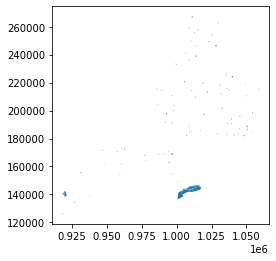

In [99]:
tax_shp.plot()

### Define Functions

In [100]:
def fuzzy_names(nameList,nl,threshold):
    '''
    fuzzy name matching algorithm - finds best name match 
    for target name (nameList) against list of name options (nl)
    
    Keyword arguments:
    nameList -- target name
    nl -- list of names to try matching with target name
    threshold -- threshold for accepting name matches (value between 0 and 1)
        i.e a .75 threshold will only consider a name match when best name 
            match is .75 or greater
    '''
    
    from difflib import SequenceMatcher as SM
    from operator import itemgetter
    matched_list = []

    for j in range(0, len(nameList)):
        ratio_list =[]
        for i in range(0, len(nl) ):
            #calculates a matching score
            ratio = SM(None, nameList[j], nl[i]).ratio()
            name = nl[i]
            #add the name to ration_list and its score 
            ratio_list.append([name, ratio])

            if i == (len(nl)-1):
                #sort score from highest to lowest
                ratio_list = sorted(ratio_list, key=itemgetter(1), reverse=True)
                # only keep match names of a certain threshold
                if (ratio_list[0][1] >= threshold):
                    matched_list.append(ratio_list[0][0])
    return(matched_list)

In [200]:
def loop_func(blacklist, date_threshold):
    '''
    for each NB in 'all_NBs' (list of NBs to analyze), this function:
    1. identifies Adjacent and Block buildings in relation to the NB
    2. identifies joint NBs (nearby buildings that are also NBs and have the 
        same owner as the NB of interest)
    3. identifies whether any of the nearby lots have the same building owner as the NB
    4. outputs CSV with the final data: 
        BBL_Description - description of the lot (Job Filing, Adjacent, Block)
        Joint_NB - joint NB status of lot (NB, Adjacent, Lot)
        Address - address of NB or same-owner matched lot
        NB_Owner - name of NB owner or name of same-owner matched lot owner
        Same_Owner - indicator, 1=lot has same owner as NB, 0=otherwise
        RPP_Owner_Not_Same - for the NB, was RPP or NB filing name used?
                             1=RPP name(s) of NB used, 0=NB filing name use
        doc_id - document ID of same-owner matched lot
        
        
    Keyword arguments:
    blacklist -- list of document types that should be filtered out
    date_threshold -- string of document date to go back to
        i.e.'2015-01-01 00:00:00' will keep documents from 2015 to present
    lot_in_block -- True or False (default)
        does the lot need to be in the block shapefile?
        False -- will include NB in output, even if not in shapefile
        True -- will break loop and go on to next NB
    '''

    # initialize dataframe for csv output
    the_df = pd.DataFrame()
    # initialize list of NB Buildings not in Pluto shapefile
    odd_NB_BBLs = []
    count = 0
    # initialize some columns in shapefile
    tax_shp["Same_Owner"] = 0 # 0 - not same owner; 1 - same owner
    tax_shp["Owner"] = 0 # NB, Same_Owner, Block
    for NB_BBL in tqdm(all_NBs, total=len(all_NBs), position=0, leave=True):
        try:
            count += 1
            if count%50==0:
                print("on", str(count), "of", str(len(all_NBs)), "NBs")

            # block of the NB
            NB_block = int(df[df["BBL"]==NB_BBL].block.drop_duplicates())
            NB_borough = int(df[df["BBL"]==NB_BBL].borough_code.drop_duplicates())
            NB_lot = int(df[df["BBL"]==NB_BBL].lot.drop_duplicates())
            
            #filter shapefile to only the block with that NB
            map_block = tax_shp[(tax_shp.BLOCK==NB_block)&(tax_shp.BORO.astype(int)==NB_borough)]

            # see if lot is in the block
            map_block_test = tax_shp[(tax_shp.BLOCK==NB_block)&(tax_shp.BORO.astype(int)==NB_borough)&(tax_shp.LOT.astype(int)==NB_lot)]
            if map_block_test.shape[0]==0:
                # list of NB Buildings not in shapefile
                odd_NB_BBLs.append(NB_BBL)
            
            # find adjacent buildings to the NB
            map_block["ADJACENT"] = None
            for index, building in map_block.iterrows():   
                # get 'not disjoint' buildings
                neighbors = map_block[~map_block.geometry.disjoint(building.geometry)].BBL.tolist()
                # remove own name from the list
                neighbors = [ bbl for bbl in neighbors if building.BBL != bbl ]
                # add names of neighbors as ADJACENT value
                map_block.at[index, "ADJACENT"] = neighbors
            adj = map_block[map_block.BBL==NB_BBL].ADJACENT.to_list()
            near_BBL = list(set([item for sublist in adj for item in sublist if item!=NB_BBL]))

            # create list of BBLs only on the block (not adjacent to the NB)
            not_adj = map_block[~map_block.BBL.isin(near_BBL)]
            not_adj = not_adj[not_adj.BBL!=NB_BBL]

            # indicate in shapefile building description: NB, Adjacent, or Block
            tax_shp.loc[tax_shp['BBL'] == NB_BBL, 'BBL_description'] = "NB"
            # if the building as already been marked as NB, do not change it to Adjacent or Block
            tax_shp.loc[tax_shp['BBL'].isin(near_BBL), 'BBL_description'] = ["ADJACENT" if x != "NB" else x for x in tax_shp.loc[tax_shp['BBL'].isin(near_BBL), 'BBL_description']]
            already_desc = ["NB", "ADJACENT"]
            tax_shp.loc[tax_shp['BBL'].isin(not_adj.BBL.tolist()), 'BBL_description'] = ["BLOCK" if x not in already_desc else x for x in tax_shp.loc[tax_shp['BBL'].isin(not_adj.BBL.tolist()), 'BBL_description']]

            ###### Do the adjacent or same-block buildings have the same owner as the NB? #####

            # filter BBLs of buildings on same block as NB in Real Properties Legal
            rpl_near_BBL =  rpl[rpl.BBL.isin(map_block.BBL.tolist())]

            #Get owner names of nearby buildings by connecting 
            #ACRIS Real Property Legals to Real Property Parties by document_id
            docids = list(rpl_near_BBL.document_id)
            rpp_near_BBL = rpp[rpp.document_id.isin(docids)]

            prop_near_BBL = pd.merge(rpl_near_BBL, rpp_near_BBL, on="document_id", how="inner", indicator=True)

            #remove whitespaces from owner name
            prop_near_BBL.name = [str(name).strip() for name in prop_near_BBL.name] 


            ### Check to see if any of the nearby buildings are NBs and the same owner (joint NB)

            map_block['RPP_Owner_Not_Same'] = "-" # 0= NB name matches RPP name; 1= NB names DOESN'T match RPP name
            backup_RPP_Owner_Not_Same = []
            nameList = df[df['BBL']== NB_BBL]['owner_s_business_name'].drop_duplicates()

            if (nameList=="NONE").any() or (nameList=="nan").any() or  "".join(nameList)=='-' or "".join(nameList)=='OWNER' or "".join(nameList)=='NA' or "".join(nameList)=='.' or "".join(nameList)=='N\A' or "".join(nameList)=='N.A.' or "".join(nameList)=='N/A'or "".join(nameList)=='NOT APPLICABLE' or "".join(nameList)=='SELF' or "".join(nameList)=="INDIVIDUAL":
#                 df[df['BBL']== NB_BBL]['owner_s_first_name'] = [name.strip() for name in df[df['BBL']== NB_BBL]['owner_s_first_name']] 
#                 df[df['BBL']== NB_BBL]['owner_s_last_name'] = [name.strip() for name in df[df['BBL']== NB_BBL]['owner_s_last_name']] 
                nameList = df[df['BBL']== NB_BBL].name #['owner_s_first_name'] + " " +  df[df['BBL']== NB_BBL]['owner_s_last_name']
                df.loc[df['BBL']== NB_BBL, 'owner_s_business_name']  = nameList
    
            # get BBL of nearby lots and see if any of them are NB filings
            near_lots = prop_near_BBL[prop_near_BBL.BBL!=NB_BBL]
            near_NB = df[df.BBL.isin(list(set(near_lots.BBL)))]

            # check that the near NBs have the same owner (using filing name)
            matched_list = fuzzy_names(nameList.tolist(),near_NB.owner_s_business_name.tolist(),.9)

            # joint lot NBs 
            joint_NBs = near_NB[near_NB.owner_s_business_name.isin(matched_list)].BBL.tolist()
            # include original NB in the joint NBs lot list
            joint_NBs.append(NB_BBL)   


            ### Check to see if the NB owner is the same as the owner listed in RPP

            # Find all document IDs associated with the NB's BBL
            NB_BBL_rpl = rpl[rpl.BBL==NB_BBL]
            # Connect ACRIS Real Property Legals to Real Property Parties by document_ids to get owner names
            NB_BBL_docids = list(NB_BBL_rpl.document_id)
            rpp_NB_BBL = rpp[rpp.document_id.isin(NB_BBL_docids)]

            # Check if RPP owner name matches NB owner name
            adjusted_nl = []
            arr = ["LLC", "INC", "N.A", "NA", "N/A"]
            # names need to be adjusted to be 'first last' instead of 'last, first' to match NB filing 
            nl = rpp_NB_BBL.name.tolist()
            for name in nl:
                adjust_name = str(name).split(",")
                adjust_name = [i.strip() for i in adjust_name]
                if len(adjust_name)>1:
                    if any(re.findall('|'.join(arr), adjust_name[1])):
                        adjust_name = adjust_name[0] + " " + adjust_name[1]
                        adjusted_nl.append(adjust_name)
                    else:
                        adjust_name = adjust_name[1] + " " + adjust_name[0]
                        adjusted_nl.append(adjust_name)
                if len(adjust_name)==1:
                    adjusted_nl.append("".join(adjust_name))

            # Check for NB name in RPP 
            matched_list_NB_RPP = fuzzy_names(nameList.tolist(),adjusted_nl,.9)

            #### Need to use RPL name instead of NB owner name
                 # NB name does not match in RPP and there was RPL data on NB (NB filing name!=RPP name)
            if (len(matched_list_NB_RPP)==0) and (NB_BBL_rpl.shape[0]>=1):
                map_block.loc[map_block.BBL==NB_BBL, 'RPP_Owner_Not_Same'] = 1
                backup_RPP_Owner_Not_Same.append(1)

                # keep only documents from the past decade, and certain document types
                prop_near_BBL = pd.merge(prop_near_BBL, rpm, on="document_id", how="left")
                prop_near_BBL = prop_near_BBL[(prop_near_BBL.doc_date > date_threshold) & ~(prop_near_BBL.doc_type.isin(blacklist))]

                # list of RPP names associated with the building
                NB_prop = prop_near_BBL[prop_near_BBL.BBL==NB_BBL]

                # keep most recent names associated with the NB
                NB_prop = NB_prop.loc[NB_prop['doc_date']==NB_prop['doc_date'].max()]

                if NB_prop.shape[0] >=1:
                    nameList = NB_prop.name.drop_duplicates().tolist()
                elif NB_prop.shape[0] ==0:
                    # sometimes NB_prop is blank, giving no name to the NB - this fixes
                    nameList = df[df['BBL']== NB_BBL]['owner_s_business_name'].drop_duplicates().tolist()

                # Search owner names in nearby buildings to match owner of RPP
                    # remove NB BBL from list of owner names
                prop_near_BBL = prop_near_BBL[prop_near_BBL.BBL!=NB_BBL]
                # exclude joint NB BBLs from same_owner matching
                if len(joint_NBs) > 1:
                    prop_near_BBL = prop_near_BBL[~prop_near_BBL.BBL.isin(joint_NBs)]

                # filter party of certain document types
                prop_near_BBL = prop_near_BBL[~((prop_near_BBL.doc_type.isin(["DEED"])) & (prop_near_BBL.party_type==1))]
                prop_near_BBL = prop_near_BBL[~((prop_near_BBL.doc_type.isin(["RPTT"])) & (prop_near_BBL.party_type==1))]
                prop_near_BBL = prop_near_BBL[~((prop_near_BBL.doc_type.isin(["AALR"])) & (prop_near_BBL.party_type==2))]
                prop_near_BBL = prop_near_BBL[~((prop_near_BBL.doc_type.isin(["AL&R"])) & (prop_near_BBL.party_type==2))]
   
                nl = prop_near_BBL.name.tolist() 

                matched_list = fuzzy_names(nameList,nl,.75)

                # find BBLs of other nearby buildings that the NB owner owns
                near_BBL_owner = prop_near_BBL[prop_near_BBL.name.isin(matched_list)]
                # of the nearby BBLs that the NB owner also owns, keep most recent only for output
                near_BBL_owner = near_BBL_owner.loc[near_BBL_owner.groupby('BBL').doc_date.idxmax()]

                same_owner = []
                for bbl in near_BBL_owner.BBL.tolist():
                    if bbl != NB_BBL:
                        same_owner.append(bbl)

                map_block['doc_id'] = "-"      
                map_block['NB_OWNER'] = "-"
                if (len(same_owner)>0):
                    if len(near_BBL_owner.name.drop_duplicates().tolist())==1:
                        map_block.loc[map_block.BBL.isin(same_owner), 'NB_OWNER'] = near_BBL_owner.name.drop_duplicates().tolist()

                    for i,j,k in zip(same_owner, near_BBL_owner.name.tolist(), near_BBL_owner.document_id.tolist()):
                        map_block.loc[map_block.BBL==i, 'NB_OWNER'] = j
                        map_block.loc[map_block.BBL==i, 'doc_id'] = k

            ### Proceed as normal (NB filing name==RPP name)
                # NB name does match in RPP or there was no RPL data on NB
            if (len(matched_list_NB_RPP)>=1) or (NB_BBL_rpl.shape[0]==0):
                map_block.loc[map_block.BBL==NB_BBL, 'RPP_Owner_Not_Same'] = 0
                backup_RPP_Owner_Not_Same.append(1)

                # keep only documents from the past decade, and certain document types
                prop_near_BBL = pd.merge(prop_near_BBL, rpm, on="document_id", how="left")
                prop_near_BBL = prop_near_BBL[(prop_near_BBL.doc_date > date_threshold) & ~(prop_near_BBL.doc_type.isin(blacklist))] 

                # Search owner names in nearby buildings to match owner of NB
                    # remove NB BBL from list of owner names
                prop_near_BBL = prop_near_BBL[prop_near_BBL.BBL!=NB_BBL]
                    # exclude joint NB BBLs from same_owner matching
                if len(joint_NBs) > 1:
                     prop_near_BBL = prop_near_BBL[~prop_near_BBL.BBL.isin(joint_NBs)]

                # filter party of certain document types
                prop_near_BBL = prop_near_BBL[~((prop_near_BBL.doc_type.isin(["DEED"])) & (prop_near_BBL.party_type==1))]
                prop_near_BBL = prop_near_BBL[~((prop_near_BBL.doc_type.isin(["RPTT"])) & (prop_near_BBL.party_type==1))]
                prop_near_BBL = prop_near_BBL[~((prop_near_BBL.doc_type.isin(["AALR"])) & (prop_near_BBL.party_type==2))]
                prop_near_BBL = prop_near_BBL[~((prop_near_BBL.doc_type.isin(["AL&R"])) & (prop_near_BBL.party_type==2))]

                nl = prop_near_BBL.name.tolist() 

                adjusted_nl = []
                # names need to be adjust to be 'first last' instead of 'last, first'
                for name in nl:
                    adjust_name = str(name).split(",")
                    adjust_name = [i.strip() for i in adjust_name]
                    if len(adjust_name)>1:
                        if any(re.findall('|'.join(arr), adjust_name[1])):
                            adjust_name = adjust_name[0] + " " + adjust_name[1]
                            adjusted_nl.append(adjust_name)
                        else:
                            adjust_name = adjust_name[1] + " " + adjust_name[0]
                            adjusted_nl.append(adjust_name)       
                    if len(adjust_name)==1:
                        adjusted_nl.append("".join(adjust_name))

                matched_list = fuzzy_names(nameList.tolist(),adjusted_nl,.75)

                # find original documented name of match, so in final output, it doesn't show
                # up as 'last, first'
                if len(matched_list)==1:
                    for ind, name in enumerate(adjusted_nl):
                        if name in matched_list:
                            same_owner_ind = ind

                    near_BBL_owner = prop_near_BBL[prop_near_BBL.name.isin([nl[same_owner_ind]])]

                if len(matched_list)>1:
                    for ind, name in enumerate(adjusted_nl):
                        if name in matched_list:
                            same_owner_ind = ind

                    nl = np.array(nl)
                    near_BBL_owner = prop_near_BBL[prop_near_BBL.name.isin(list(nl[same_owner_ind]))]

                # will be empty, but will restart df from last loop 
                if len(matched_list)==0:
                    near_BBL_owner = prop_near_BBL[prop_near_BBL.name.isin(matched_list)]

                same_owner = []
                for bbl in near_BBL_owner.BBL.tolist():
                    if bbl != NB_BBL:
                        same_owner.append(bbl)

                # find BBLs of other nearby buildings that the NB owner owns
                map_block['doc_id'] = "-" 
                map_block['NB_OWNER'] = "-"
                if (len(same_owner)>0):
                    map_block.loc[map_block.BBL.isin(same_owner), 'NB_OWNER'] = near_BBL_owner.name.drop_duplicates().tolist()

                    for i,j,k in zip(same_owner, near_BBL_owner.name.tolist(), near_BBL_owner.document_id.tolist()):
                        map_block.loc[map_block.BBL==i, 'NB_OWNER'] = j
                        map_block.loc[map_block.BBL==i, 'doc_id'] = k

                        
        ### uncomment this section if you want owner name and document IDs of associated joint NBs      
#                 # If no success, just in case, search other NBs first/last names to see if any of those have the same owner 
#                 near_nb = []
#                 if (len(same_owner)==0): #==True: 
#                     nl = df['name'].tolist()
#                     matched_list = fuzzy_names(nameList.tolist(),nl,.75)

#                     near_BBL_owner = df[df.name.isin(matched_list)]
#                     near_BBL_owner = near_BBL_owner.drop_duplicates("BBL")

#                     for bbl in near_BBL_owner.BBL.tolist():
#                         if bbl != NB_BBL:
#                             near_nb.append(bbl)

#                     map_block.loc[map_block.BBL.isin(near_nb), 'NB_OWNER'] = near_BBL_owner.name.drop_duplicates().tolist()

#                 # If no success again, just in case, search other NBs organization names to see if any of those have the same owner      
#                 if (len(same_owner)==0):  
#                     nl = df.owner_s_business_name.tolist()
#                     matched_list = fuzzy_names(nameList.tolist(),nl,.75)

#                     near_BBL_owner = df[df.owner_s_business_name.isin(matched_list)]
#                     near_BBL_owner = near_BBL_owner.drop_duplicates("BBL")

#                     for bbl in near_BBL_owner.BBL.tolist():
#                         if bbl != NB_BBL:
#                             near_nb.append(bbl)

#                     # sometimes there are very similar (but still slightly different) names
#                     try:
#                         map_block.loc[map_block.BBL.isin(near_nb), 'NB_OWNER'] = near_BBL_owner.owner_s_business_name.drop_duplicates().tolist()
#                     except:
#                         map_block.loc[map_block.BBL.isin(near_nb), 'NB_OWNER'] = near_BBL_owner.owner_s_business_name.drop_duplicates().tolist()[0]

            # correct the descriptions of adjacent/block buildings if there are joint NBs
            if len(joint_NBs) > 1:
                map_block["ADJACENT_UPDATE"] = None
                for index, building in map_block.iterrows():   
                    # get 'not disjoint' buildings
                    neighbors = map_block[~map_block.geometry.disjoint(building.geometry)].BBL.tolist()
                    # remove own name from the list
                    neighbors = [ bbl for bbl in neighbors if building.BBL != bbl ]
                    # add names of neighbors as ADJACENT value
                    map_block.at[index, "ADJACENT_UPDATE"] = neighbors

                adj_update = map_block[map_block.BBL.isin(joint_NBs)].ADJACENT_UPDATE.to_list()
                near_BBL_update = [item for sublist in adj_update for item in sublist if item not in joint_NBs]

                # update list of BBLs only on the block (not adjacent to the NB)
                not_adj_update = map_block[~map_block.BBL.isin(near_BBL_update)]
                not_adj_update = not_adj_update[~not_adj_update.BBL.isin(joint_NBs)]


            # indicate in the shapefile building description: NB, Adjacent, or Block
            tax_shp.loc[tax_shp['BBL'] == NB_BBL, 'BBL_description'] = "NB"
            # if the building has already been marked as NB, do not change it to Adjacent or Block
            tax_shp.loc[tax_shp['BBL'].isin(near_BBL), 'BBL_description'] = ["ADJACENT" if x != "NB" else x for x in tax_shp.loc[tax_shp['BBL'].isin(near_BBL), 'BBL_description']]
            already_desc = ["NB", "ADJACENT"]
            tax_shp.loc[tax_shp['BBL'].isin(not_adj.BBL.tolist()), 'BBL_description'] = ["BLOCK" if x not in already_desc else x for x in tax_shp.loc[tax_shp['BBL'].isin(not_adj.BBL.tolist()), 'BBL_description']]


            # indicate in shapefile joint NBs: NB (all those on block with same owner), Adjacent, or Block
            if len(joint_NBs) > 1:
                tax_shp.loc[tax_shp['BBL'].isin(joint_NBs), 'Joint_NBs'] = "NB"
                # if the building has already been marked as NB, do not change it to Adjacent or Block
                tax_shp.loc[tax_shp['BBL'].isin(near_BBL_update), 'Joint_NBs'] = ["ADJACENT" if x != "NB" else x for x in tax_shp.loc[tax_shp['BBL'].isin(near_BBL_update), 'Joint_NBs']]
                already_desc = ["NB", "ADJACENT"]
                tax_shp.loc[tax_shp['BBL'].isin(not_adj_update.BBL.tolist()), 'Joint_NBs'] = ["BLOCK" if x not in already_desc else x for x in tax_shp.loc[tax_shp['BBL'].isin(not_adj_update.BBL.tolist()), 'Joint_NBs']]
            if len(joint_NBs)==1:
                tax_shp.loc[tax_shp['BBL'].isin(joint_NBs), 'Joint_NBs'] = "NB"
                # if the building has already been marked as NB, do not change it to Adjacent or Block
                tax_shp.loc[tax_shp['BBL'].isin(near_BBL), 'Joint_NBs'] = ["ADJACENT" if x != "NB" else x for x in tax_shp.loc[tax_shp['BBL'].isin(near_BBL), 'Joint_NBs']]
                already_desc = ["NB", "ADJACENT"]
                tax_shp.loc[tax_shp['BBL'].isin(not_adj.BBL.tolist()), 'Joint_NBs'] = ["BLOCK" if x not in already_desc else x for x in tax_shp.loc[tax_shp['BBL'].isin(not_adj.BBL.tolist()), 'Joint_NBs']]


            # Make buildings on the same block as the NB with the same owner '1'
            tax_shp.loc[tax_shp['BBL'].isin(same_owner), 'Same_Owner'] = 1

            # indicate in shapefile building owner: NB, Same Owner as NB, and Block
            tax_shp.loc[tax_shp['BBL'] == NB_BBL, 'Owner'] = "NB"
            if len(joint_NBs) > 1:
                tax_shp.loc[tax_shp['BBL'].isin(joint_NBs), 'Owner'] = "NB"
            # if the building has already been marked as NB, do not change it to Same Owner as NB or Block
            tax_shp.loc[tax_shp['BBL'].isin(same_owner), 'Owner'] = ["Same Owner as NB" if x != "NB" else x for x in tax_shp.loc[tax_shp['BBL'].isin(same_owner), 'Owner']]
            # if the building has already been marked as NB or Same Owner, do not change it to Block
            already_own = ["NB", "Same Owner as NB"]
            adj_list = [item for sublist in adj for item in sublist]
            tax_shp.loc[tax_shp['BBL'].isin(adj_list), 'Owner'] = ["Block" if x not in already_own else x for x in tax_shp.loc[tax_shp['BBL'].isin(adj_list), 'Owner']]
            tax_shp.loc[tax_shp['BBL'].isin(not_adj.BBL.tolist()), 'Owner'] = ["Block" if x not in already_own else x for x in tax_shp.loc[tax_shp['BBL'].isin(not_adj.BBL.tolist()), 'Owner']]


            #### CSV output ####

            # if NB BBL is not in shapfile, need to create a custom row that includes NB data for output
            if map_block[map_block.BBL==NB_BBL].shape[0]==0:
                map_block = map_block.append(pd.Series(), ignore_index=True)
                map_block.loc[map_block.BBL.isna(), "BBL"] = NB_BBL
                map_block.loc[map_block.BBL==NB_BBL, "BORO"] = NB_borough
                map_block.loc[map_block.BBL==NB_BBL, "RPP_Owner_Not_Same"] = backup_RPP_Owner_Not_Same
                map_block.loc[map_block.BBL==NB_BBL, "doc_id"] = "-"

            # Create column of all BBLs (NB, adjacent, on block)                
            BBL_col = [NB_BBL] + near_BBL + not_adj.BBL.tolist()

            ## Create job filing column
            job_filing = ["NB"]
            other_buildings = ["-"] * (len(BBL_col)-1)
            job_filing += other_buildings

            # Create building description column
            nb_desc = ["Job Filing"]
            adj_desc = ["Adjacent"] * len(near_BBL)
            block_desc = ["Block"] * len(not_adj)
            building_desc = nb_desc + adj_desc + block_desc

            # Create joint_NBs description column
            map_block['JOINT_NBs'] = "-"
            if len(joint_NBs) > 1:
                map_block.loc[map_block.BBL.isin(joint_NBs), 'JOINT_NBs'] = "NB"
                map_block.loc[map_block.BBL.isin(near_BBL_update), 'JOINT_NBs'] = "Adjacent"
                map_block.loc[map_block.BBL.isin(not_adj_update.BBL.tolist()), 'JOINT_NBs'] = "Block"
            if len(joint_NBs)==1:
                map_block.loc[map_block.BBL==NB_BBL, 'JOINT_NBs'] = "NB"
                map_block.loc[map_block.BBL.isin(near_BBL), 'JOINT_NBs'] = "Adjacent"
                map_block.loc[map_block.BBL.isin(not_adj.BBL.tolist()), 'JOINT_NBs'] = "Block"

            # NB address column
            NB_ADDRESS = list(df[df['BBL']== NB_BBL].NB_ADDRESS.drop_duplicates())
             # in case there are multiple addresses listed for the same NB, chose the first address listed
            if (len(NB_ADDRESS)>1):
                NB_ADDRESS = NB_ADDRESS[0]

            # indicator column - 1 near BBL has same owner as NB, None otherwise
            map_block["SAME_OWN"] = 0
            sameown = map_block[map_block.BBL.isin(same_owner)]
            map_block.loc[sameown.index, 'SAME_OWN'] = 1

            map_block = map_block.set_index('BBL')

            #make sure all nearby lots are in NYC lot shapefile
            map_block = map_block.loc[[i for i in BBL_col if i in map_block.index.tolist()]]
            map_block['NB_ADDRESS'] = "-"
            NB_OWNER = ["; ".join(nameList)]

            map_block.loc[map_block.index == NB_BBL, 'NB_OWNER'] = NB_OWNER
            map_block.loc[map_block.index == NB_BBL, 'NB_ADDRESS'] = NB_ADDRESS
            near_address = near_BBL_owner[near_BBL_owner.BBL.isin(same_owner)]
            try:
                street_number = ["—" if x == "nan" else x.strip() for x in near_address.street_number.tolist()]
            except:
                bool_near_owner = near_BBL_owner.BBL.isin(same_owner)
                near_address = near_BBL_owner[bool_near_owner]
                near_address = near_address[near_address.block==NB_block]
                street_number = ["—" if x == "nan" else x.strip() for x in near_address.house__.tolist()]
            street_name = ["—" if x == "nan" else x.strip() for x in near_address.street_name.tolist()]
            near_address = [m+str(" ")+str(n) for m,n in zip(street_number, street_name)]
            near_address = ["—" if x == "— —" else x for x in near_address]
            near_address = [x[2:] if x.split()[0] == "—" else x for x in near_address]

            if (len(map_block.loc[map_block.index.isin(same_owner)])==1):
                near_address = near_address[0]
                map_block.loc[map_block.index.isin(same_owner), 'NB_ADDRESS'] = near_address
            if (len(map_block.loc[map_block.index.isin(same_owner)])==len(near_address)):
                map_block.loc[map_block.index.isin(same_owner), 'NB_ADDRESS'] = near_address
            try:
                if (len(map_block.loc[map_block.index.isin(same_owner)])>1) & (len(map_block.loc[map_block.index.isin(same_owner)])!=len(near_address)):
                    near_address = list(dict.fromkeys(near_address))
                    map_block.loc[map_block.index.isin(same_owner), 'NB_ADDRESS'] = near_address  
            except:
                if (len(map_block.loc[map_block.index.isin(same_owner)])!=len(near_address)):
                    map_block.loc[map_block.index.isin(same_owner), 'NB_ADDRESS'] = ["-"] * len(map_block.loc[map_block.index.isin(same_owner), 'NB_ADDRESS'])

            # add dash if there's a blank
            map_block.NB_ADDRESS = ["-" if x == "" else x for x in list(map_block.NB_ADDRESS)]

            # Bind all columns together to create csv
            csvdf = pd.DataFrame(list(zip(BBL_col, job_filing, building_desc, list(map_block.JOINT_NBs), list(map_block.NB_ADDRESS), list(map_block.NB_OWNER), list(map_block.SAME_OWN), list(map_block.RPP_Owner_Not_Same), list(map_block.doc_id))), 
                               columns =['BBL', 'Job_Filing', 'BBL_Description', 'Joint_NBs','Address', 'NB_Owner', "Same_Owner", "RPP_Owner_Not_Same", "doc_id"])

            the_df = the_df.append(csvdf, ignore_index=True)

        except:
            # list of NB Buildings not in shapefile
            odd_NB_BBLs.append(NB_BBL)
            
    return(the_df, odd_NB_BBLs)


#### Define list of NBs to analyze in the model

In [102]:
# list of NBs to run through in the model
all_NBs = list(df.BBL.unique())

In [103]:
len(all_NBs)

100

# Model

In [104]:
### set path for data output
model_output = "model_output/"

### Run single model

In [118]:
blacklist =  ["PREL", "REL", "RTXL", "SAGE", "TERA", "TL&R", "TLS", "SAT", "CERT",
     "ASST", "DECL","EASE", "AGMT", "MTGE","AALR","AIRRIGHT","CDEC","CORRD",
     "CTOR","DEEDO","RPTT&RET", "PAT", "MCON"]

date_threshold = str(int(s[:4])-2)+'-01-01 00:00:00'

In [201]:
tax_shp = gpd.read_file(shapefile_saved_path + "NB_lots_blocks.shp")

## main loop here
the_df, odd_NB_BBLs = loop_func(blacklist, date_threshold)
# odd_NB_BBLs = list of NBs not in shapefile

## save as "FilterYear_#ofDocsBlacklisted"
the_df.to_csv(model_output+"Filter"+str(int(s[2:4]) - int(date_threshold[2:4])).zfill(2)+"_"+ str(len(blacklist)-9)+".csv", index=False)

# join output with Real Property Master's for information on document types
final = pd.merge(the_df, rpm, left_on="doc_id", right_on="document_id", how="left")
final = final.fillna("-")
final = final.drop("document_id", axis=1)

## final csv
final.to_csv(model_output+"Filter"+str(int(s[2:4]) - int(date_threshold[2:4])).zfill(2)+"_"+str(len(blacklist)-9)+"-doc_data.csv", index=False)
print('saved'+" Filter"+str(int(s[2:4]) - int(date_threshold[2:4])).zfill(2)+"_"+str(len(blacklist)-7)+"!")

# list of BBLs not in the shapefile
d = {'BBL': odd_NB_BBLs}
odd_NB_BBLs_df = pd.DataFrame(data=d)
odd_NB_BBLs_df.to_csv(model_output+"Filter"+str(int(s[2:4]) - int(date_threshold[2:4])).zfill(2)+"_"+str(len(blacklist)-9)+"-BBLs_not_in_shp.csv", index=False)


## save final shapefile
    ## removes lots not analyzed in run
tax_shp = tax_shp[~tax_shp.BBL_description.isna()] 
tax_shp.to_file(model_output+"Filter"+str(int(s[2:4]) - int(date_threshold[2:4])).zfill(2)+"_"+str(len(blacklist)-9)+".shp")


on 50 of 100 NBs
on 100 of 100 NBs

saved Filter02_16!
